In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install scipy 
#!pip install pandastable
#!pip install sympy
#!pip install math

In [2]:
import numpy as np
from numpy import trapz

import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib import cm

import matplotlib 
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

import scipy
from scipy.interpolate import interp1d
from scipy import optimize

import math

import pandas as pd
from pandastable import Table, TableModel, config

import csv

import sympy
from sympy import integrate, log, exp, oo

from sympy.abc import a, x, y

import tkinter as tk
from tkinter import filedialog as fd

root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)


''

# User Input Files

Running the following block of code will initiate a request for user data. This code can run multiple test cells and underwater spectrums at once. The request will appear from a separate window displaying your files. To run several tests at the same time all files must be highlighted at once. Examples will be shown in the paper published : [LINK] and the files mentioned in this section of the code can all be found in the Github Repository: https://github.com/EdSartor/Solar 

The LED file (1) given in the Github Repository is specifically for the VeraSol-2 Class AAA simulator, and the underwater spectra for 2-9m is from Jenkin's water absorption data. 
Please select, in order:

##### 1: LED data file from  the LED simulator used  (LEDspectra.csv)
  
**Column 1**: Wavelength  
**Column 2+**: Irradiance per meter squared per nanometer for each individual LED. 

No header is used.

##### 2: Desired Underwater Spectrum (Can choose multiple from 2m, 3m, 4m, 5m, 6m, 7m, 8m, and 9m.csv)
  
**Column 1**: wavelength  
**Column 2+**: irradiance per meter squared per nanometer
   
Header of the first column is "wl" for "wavelength", while header for the second column is the name of the spectrum.
 
##### 3: AM1.5G Data (AM1.5G.csv)
 
**Column 1**: wavelength  
**Column 2**: irradiance per meter squared per nanometer

#### 4: Reference Cell EQE (Si_refEQE.csv)
  
**Column 1**: wavelength  
**Column 2**: EQE (in %)

#### 5: Test Cell EQE  (Can choose multiple from cdte_EQE, c-Si_EQE, and GaInP_EQE.csv) 

**Column 1**: wavelength  
**Column 2+**: EQE (in %)

If a different spectra of another body of water is desired, another code, SpectraMake, is in the GitHub and can create spectra for you at different depths.


#### NOTE: 
In the following cell, Isc_ref must be inputed in terms of mA for compatibility with any of the files in the GitHub. If other data is used, units might differ as the Isc of the reference cell will be solar cell Specific. 

# Import and Plot the LED Spectrum

This block of code will:  
1: Import underwater irradiance spectra.

2: Compress the format for LED Matching calculation.

3: Identify the LED input settings to match the underwater spectra.

Outputs:  
**Plot 1:** Baseline outputs for individual LED irradiance profiles. 

**Plot 2:** Underwater Irradiance Spectra at the selected depth(s)

**Plot 3:** Target spectrum and output spectrum based on the calculated values from this python scrip. Dashed lines are used to define the quality/accuracy of the fit. 

**Plot 4:** Spectral response(s) of the test cell(s) and the corresponding EQE(s) compared to the reference cell. 

**Text File:**  
Contains LED settings and spectra properties. Will be in same folder as input spectrum and named "*SpectrumName*+_LEDsettings.txt"

In [3]:
LED_file = fd.askopenfilename()
UnderwaterSpectra = fd.askopenfilenames()
AM15g = fd.askopenfilenames()
Reference_EQE = fd.askopenfilename()
Test_EQEs = fd.askopenfilenames()

Isc_Reference = 136.56

2m - calculation complete


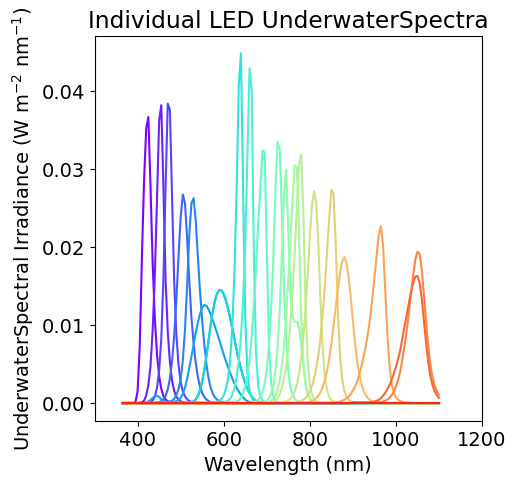

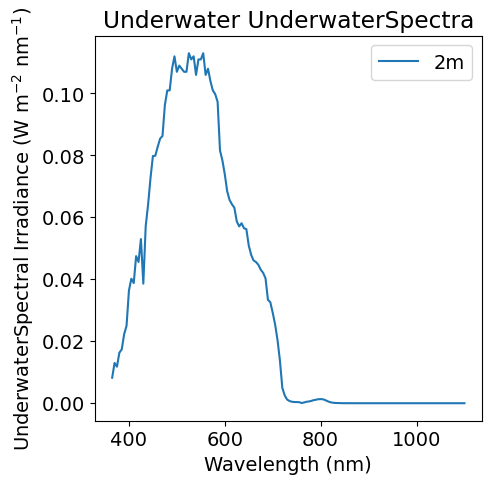

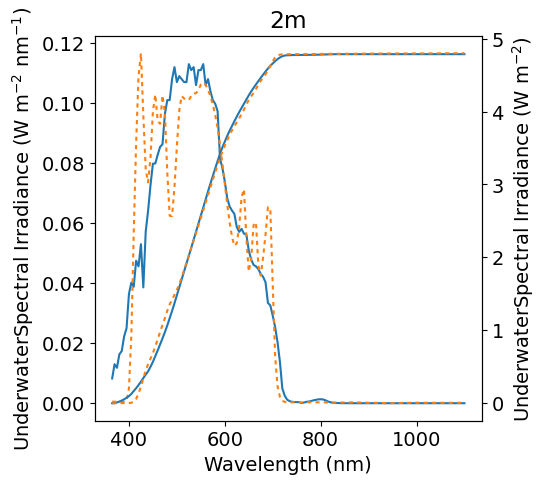

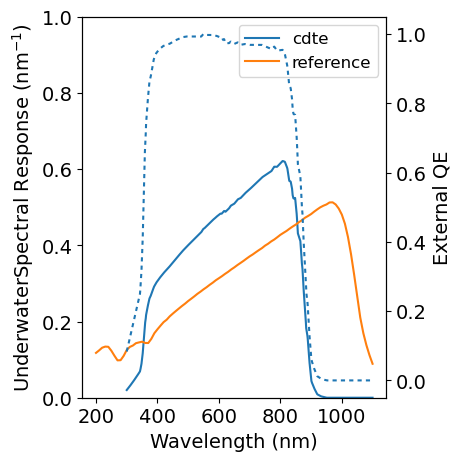

In [4]:
#This code may take a while to run. 

# ----------------Import LED Spectra---------
fig, axs = plt.subplots(figsize = (5,5))

A = pd.read_table(LED_file)
n_LEDs = np.arange(A.shape[1]-1)

##---------Instantiate Dataframes------------
df2 = pd.DataFrame()

LED_cols = []
for i in range(0,n_LEDs[-1]+1):
    LED_cols.append('LED '+str(n_LEDs[i]+1))

name_list=[]
for i in range(0,len(UnderwaterSpectra)):
    name = UnderwaterSpectra[i].split('/')[-1]
    name = name.split('.')[0]
    name_list.append(name)

LED_index=[]
LED_index = LED_cols
LED_index[:0] = ['wv']

A = pd.read_table(LED_file,names=LED_index,index_col=False,header=0)
colors = plt.cm.rainbow(np.linspace(0, 1, len(n_LEDs)))

for i in range(0,n_LEDs[-1]):
    axs.plot(A['wv'],A['LED '+str(i+1)],c=colors[i])
    
    
axs.set_xlabel('Wavelength (nm)')
axs.set_ylabel('UnderwaterSpectral Irradiance (W m$^{-2}$ nm$^{-1}$)')
axs.set_title('Individual LED UnderwaterSpectra')
axs.set_xlim(300,1200)

#-----------Import Spectra-------------
fig2, axs = plt.subplots(figsize=(5,5))

df_UnderwaterSpectra = pd.DataFrame()
for i in range(0,len(UnderwaterSpectra)):
    if i == 0:
        df_UnderwaterSpectra['wv'] = A['wv']
    B = pd.read_csv(UnderwaterSpectra[i],header=0,names=['wv','ir'])
  
    temp = []
    for k in range(0,len(A['wv'])):
        a = A['wv'][k]
        b = B.index[B['wv'] == a]
        
        #print("0", b)
        #print("a", type(B['ir'][b]))
        #display("b", B['ir'])
        
        temp.append(float(B['ir'][b]))

    df_UnderwaterSpectra[name_list[i]]= temp

#--------Identify lost power--------------
    endlam = (B.index[B['wv'] == A['wv'][0]])[0]
    startlam = (B.index[B['wv'] == A['wv'][len(A['wv'])-1]])[0]
    UV_missed_I = np.trapz(B['ir'][0:endlam])
    IR_missed_I = np.trapz(B['ir'][startlam:])
    total_I = np.trapz(B['ir'])

    axs.plot(df_UnderwaterSpectra['wv'],df_UnderwaterSpectra[name_list[i]])
    df2[str(name_list[i])]=[UV_missed_I,IR_missed_I,total_I]
    
start_nm = df_UnderwaterSpectra['wv'][0]
end_nm = df_UnderwaterSpectra['wv'].to_numpy()[-1]

axs.set_xlabel('Wavelength (nm)')
axs.set_ylabel('UnderwaterSpectral Irradiance (W m$^{-2}$ nm$^{-1}$)')
axs.set_title('Underwater UnderwaterSpectra')
axs.legend(labels=name_list)

#----------------Define Cost Functions for Fitting Procedure----------
def myfunc(X,args):
    args[0] = L
    args[1] = S
    out = np.dot(L,X)
    cost = np.trapz(abs(S-out))
    return cost

def myfunc2(X,args):
    args[0] = L
    args[1] = S
    out = np.dot(L,X)
    int_out=np.zeros(len(out))
    int_S=np.zeros(len(S))
    for i in range(0,len(out)):
        int_out[i] = np.trapz(out[0:i])
        int_S[i]=np.trapz(S[0:i])
    cost = np.trapz(abs(int_S-int_out))
    return cost

#-----------------Fit LEDs to Spectrum----------------------------------
#------IMPORTANT-------Adjust Bounds if using different Solar Sim-------
L = A[LED_cols[1:]].to_numpy()
bound = [(0,70),(0,67),(0,47),(0,68),(0,66),(0,98),(0,96),(0,42),(0,82),(0,141),(0,100),(0,34),(0,105),(0,24),(0,112),(0,94),(0,42),(0,50),(0,165),(0,1),(0,2),(0,0),(0,0),(0,0)]
df_LEDset = pd.DataFrame(index = LED_cols[1:])

x0 = []
for i in range(0,len(bound)):
    x0.append(np.random.rand()*bound[i][0])

for i in range(0,len(name_list)):
    S = df_UnderwaterSpectra[name_list[i]].to_numpy()
    
    Sol = optimize.minimize(myfunc,x0,args=[L,S],bounds=bound, method='Powell')
    x1 = Sol.x
    Sol2 = optimize.minimize(myfunc2,x1,args=[L,S],bounds=bound, method='Powell')
    print(name_list[i] + ' - calculation complete')

    LED_values = np.round(Sol2.x,0)
    df_LEDset[name_list[i]] = LED_values

#----------------Plot Fitted Spectra vs. Target Spectra-------------
if len(name_list) == 1:
    fig3, axs = plt.subplots(figsize=(5,5))
    for i in range(0,len(name_list)):
            out = np.dot(L,df_LEDset[name_list[i]])
            total_I = np.trapz(out)
            S = df_UnderwaterSpectra[name_list[i]]

            int_out=np.zeros(len(out))
            int_S=np.zeros(len(S))
            for j in range(0,len(out)):
                int_out[j] = np.trapz(out[0:j])
                int_S[j]=np.trapz(S[0:j])

            ax2 = axs.twinx()
            ax2.plot(df_UnderwaterSpectra['wv'],int_S)
            axs.plot(df_UnderwaterSpectra['wv'],S)
            axs.plot(df_UnderwaterSpectra['wv'],out, dashes = [2,2])
            ax2.plot(df_UnderwaterSpectra['wv'],int_out, dashes = [2,2])
            axs.set_xlabel('Wavelength (nm)')
            axs.set_ylabel('UnderwaterSpectral Irradiance (W m$^{-2}$ nm$^{-1}$)')
            ax2.set_ylabel('UnderwaterSpectral Irradiance (W m$^{-2}$)')
            axs.set_title(name_list[i])
else:
    n_plots = int(np.ceil(np.sqrt(len(name_list))))

    fig3, axs = plt.subplots(n_plots, n_plots, figsize=(10,10))

    for i in range(0,len(name_list)):
        x_plt = np.mod(i,n_plots)
        y_plt = int(np.floor(i/n_plots))
        out = np.dot(L,df_LEDset[name_list[i]])
        total_I = np.trapz(out)
        S = df_UnderwaterSpectra[name_list[i]]

        int_out=np.zeros(len(out))
        int_S=np.zeros(len(S))
        for j in range(0,len(out)):
            int_out[j] = np.trapz(out[0:j])
            int_S[j]=np.trapz(S[0:j])

        ax2 = axs[x_plt,y_plt].twinx()
        ax2.plot(A['wv'],int_S)
        axs[x_plt,y_plt].plot(A['wv'],S)
        axs[x_plt,y_plt].plot(A['wv'],out, dashes = [2,2])
        ax2.plot(A['wv'],int_out, dashes = [2,2])
        axs[x_plt,y_plt].set_xlabel('Wavelength (nm)')
        axs[x_plt,y_plt].set_ylabel('UnderwaterSpectral Irradiance (W m$^{-2}$ nm$^{-1}$)')
        ax2.set_ylabel('UnderwaterSpectral Irradiance (W m$^{-2}$)')
        axs[x_plt,y_plt].set_title(name_list[i])

    fig3.tight_layout(pad=1.5)

fig4, axs = plt.subplots(figsize=(5,5))

#----------------------------- Converting test device EQE into Spectral response (SR)------------------------------------

fig4_labels = []
ref = pd.read_csv(Reference_EQE,header=0,names=['wv','qe'])
ref['sr'] = ((ref['qe']/100)*(ref['wv'] / 1239.8)) #divided by 100 as the file is given in %

EQE_list = []
df_EQE = pd.DataFrame(index = name_list)

for i in range(0,len(Test_EQEs)):
    name = Test_EQEs[i].split('/')[-1]
    name = name.split('.')[0]
    name = name.split('_')[0]
    EQE_list.append(name)

df_calib = pd.DataFrame(index = name_list)
ax2 = axs.twinx()

for i in range (0,len(Test_EQEs)):
    test = pd.read_csv(Test_EQEs[i],header=0,names=['wv','qe'])
    if i == 0:
        df_EQE['wv'] = test['wv']
    test['sr'] = ((test['qe'])*(test['wv'] / 1239.8))

#------Plotting----------------
    ax2.plot(test['wv'], test['qe'], dashes = [2,2])
    axs.plot(test['wv'], test['sr'])
    fig4_labels = fig4_labels + [EQE_list[i]]
    axs.set_xlabel("Wavelength (nm)")
    axs.set_ylabel("UnderwaterSpectral Response (nm$^{-1}$)")
    ax2.set_ylabel("External QE")
    df_EQE[EQE_list[i]] = test['sr']
    
    m_list = []
    isc_list = []
    
    for Wavelength_name in name_list:
        Simulation_spectrum = np.dot(L,df_LEDset[Wavelength_name])
        Wavelength_range = np.linspace(start_nm, end_nm, num=(end_nm-start_nm+1))

        #-------interpolations-----------
        ref_f = interp1d(ref['wv'],ref['sr'])
        test_f = interp1d(test['wv'],test['sr'])
        sim_f = interp1d(df_UnderwaterSpectra['wv'],Simulation_spectrum)
        uws_f = interp1d(df_UnderwaterSpectra['wv'],df_UnderwaterSpectra[Wavelength_name])
        
        AM15g_f = interp1d(df_UnderwaterSpectra['wv'],df_UnderwaterSpectra[Wavelength_name])
        
        SR_ref = ref_f(Wavelength_range)
        SR_test = test_f(Wavelength_range)
        E_sim = sim_f(Wavelength_range)
        E_uws = uws_f(Wavelength_range)
        E_AM15g = AM15g_f(Wavelength_range)
 
        int1 = np.trapz(SR_ref * E_uws)
        int2 = np.trapz(SR_ref * E_sim)
        int3 = np.trapz(SR_test * E_sim)
        int4 = np.trapz(SR_test * E_uws)
        int5 = np.trapz(SR_ref * E_AM15g)
        
        h = int3/int4
        
        E_sim = E_sim/h
        
        int3 = np.trapz(SR_test * E_sim)
        int4 = np.trapz(SR_test * E_uws)
        int2 = np.trapz(SR_ref * E_sim)
        
        
        #-------------Spectral Mismatch Calculation -------------
        m = (int1/int2) * (int3/int4)
        m_list.append(m)
        #cn_ref = Isc_Reference/1000
        
        #------------Short Circuit Current Correction----------------
        I_uw_ref = Isc_Reference*(int1/int5)
        I_sim_ref = I_uw_ref/m
        
        isc_list.append(I_sim_ref)

    df_calib[EQE_list[i]+' M'] = m_list
    df_calib[EQE_list[i]+' Isc'] = isc_list

label = 'reference'
fig4_labels = fig4_labels+[label]
axs.plot(ref['wv'], ref['sr'])

axs.legend(fig4_labels, loc ="best", prop={'size': 12})
axs.set_ylim([0, 1])

fig4.tight_layout(pad=1.5)


In [5]:
display(df_LEDset)
print(" ")
display(df_calib)


,2m
LED 1,3.0
LED 2,2.0
LED 3,2.0
LED 4,3.0
LED 5,1.0
LED 6,7.0
LED 7,2.0
LED 8,0.0
LED 9,1.0
LED 10,1.0


,cdte M,cdte Isc
2m,0.997461,136.907568
